In [1]:
%cd /home/aditya/Documents/SolarCycleProject/code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
import src.preprocesser as pre
import src.network as network
import src.plotter as plotter
from src.hyperparams import *
%load_ext autoreload

/home/aditya/Documents/SolarCycleProject/code


Using TensorFlow backend.


In [2]:
%autoreload

In [3]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
filename = "data/SN_d_tot_V2.0.csv"
data = pd.read_csv(filename, delimiter=";", names=headers)

In [4]:
data

,Year,Month,Day,Decimal Date,Daily Total Sunspot Number,Sunspot Number Stddev,No of observations,Definitive/Provisional
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
496,1819,5,12,1819.360,0,2.0,1,1
497,1819,5,13,1819.363,0,2.0,1,1
498,1819,5,14,1819.366,0,2.0,1,1
499,1819,5,15,1819.368,28,6.7,1,1


In [6]:
# Data Preprocessing
x, y = pre.preprocess(data)

[ 0.  0.  0.  0.  0.  0.  0.  0. 28. 42.]
ymax: 202.0 ymin: 0.0
x.shape: (494,)
y.shape: (494,)


In [7]:
if mean_type == "gaussian":
    weights = gaussian(M=mean_length, std=0.1, sym=True)
    weights /= np.sum(weights) # normalise the weights
    y = pre.running_mean_helper(y, weights)
elif mean_type == "uniform":
    weights = np.ones(mean_length)/mean_length
    y = pre.running_mean_helper(y, weights)
else:
    pass


In [8]:
X = y
x_slid, y_slid = pre.sliding_window_main(X, X)
x_train, y_train, x_val, y_val, x_test, y_test = pre.data_splitting_main(x_slid, y_slid)

x_slid.shape: (492, 2, 1)
y_slid.shape: (492, 1)
x_train.shape:  (295, 2, 1)
y_train.shape:  (295, 1)
x_val.shape:  (98, 2, 1)
y_val.shape:  (98, 1)
x_test.shape:  (99, 2, 1)
y_test.shape:  (99, 1)



In [9]:
net = network.create_network()

In [10]:
history = network.trainer(net, x_train, y_train, x_val, y_val, verbose=1)
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 295 samples, validate on 98 samples
Epoch 1/100
295/295 [==============================] - 3s 12ms/step - loss: 0.0777 - val_loss: 0.0327
Epoch 2/100
295/295 [==============================] - 2s 5ms/step - loss: 0.0571 - val_loss: 0.0269
Epoch 3/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0545 - val_loss: 0.0240
Epoch 4/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0528 - val_loss: 0.0224
Epoch 5/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0513 - val_loss: 0.0212
Epoch 6/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0499 - val_loss: 0.0202
Epoch 7/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0485 - val_loss: 0.0194
Epoch 8/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0470 - val_loss: 0.0186
Epoch 9/100
295/295 [==============================] - 1s 4ms/step - loss: 0.0457 - val_loss: 0.0179
Epoch 10/100
295/295 [=======================

pred1.shape: (98, 1)
pred2.shape: (295, 1)


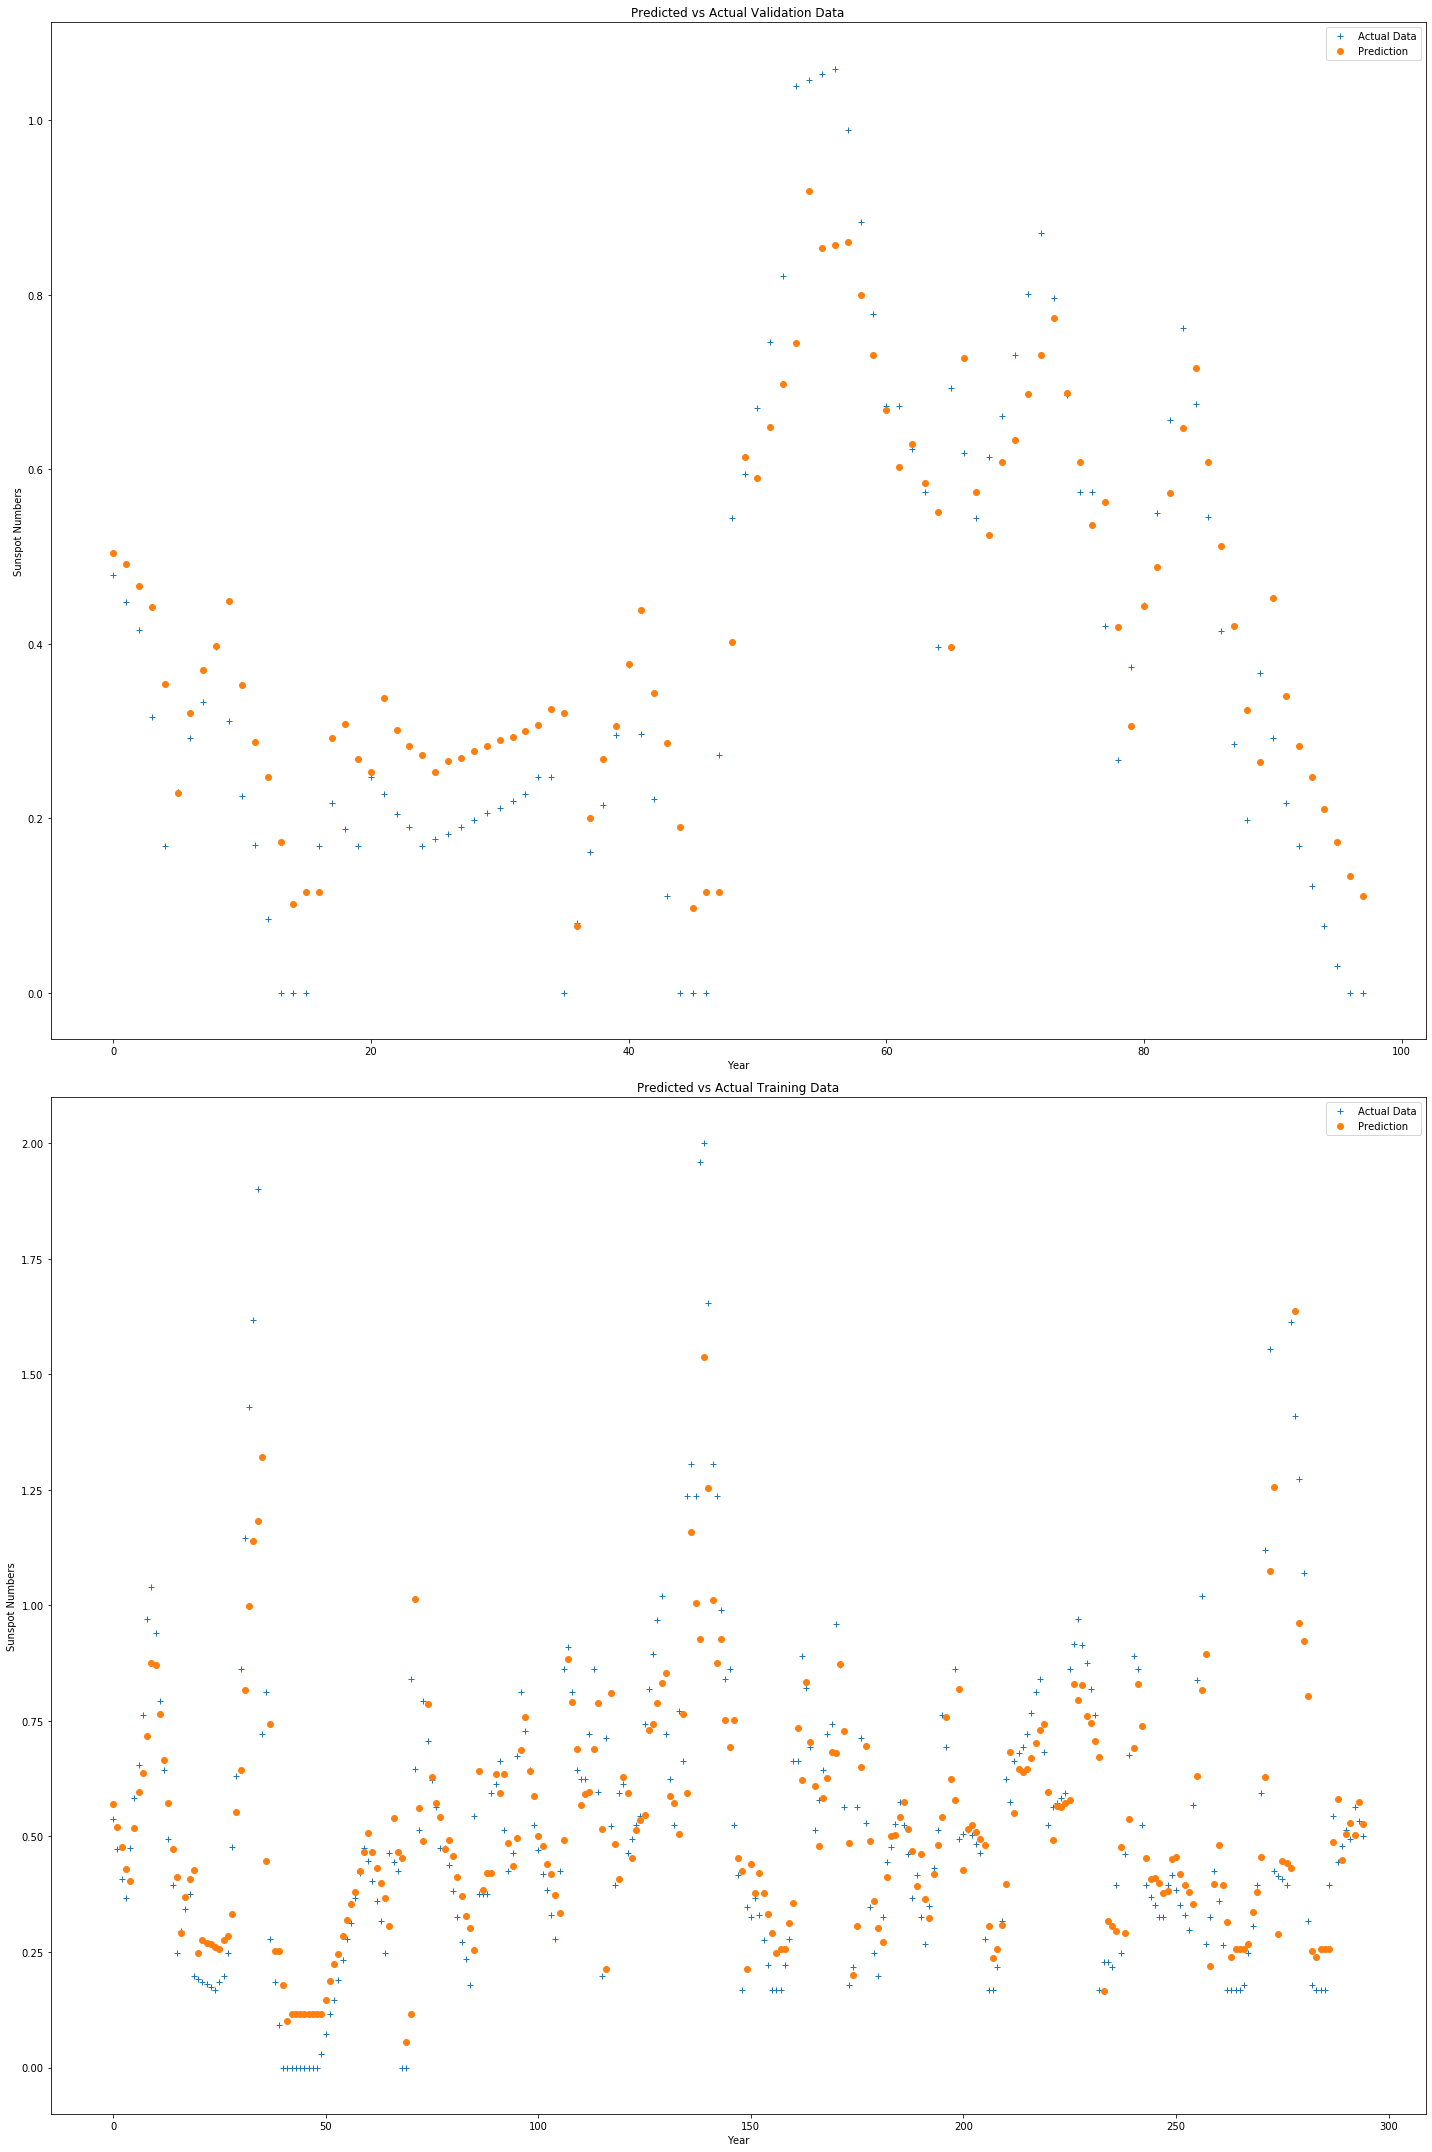

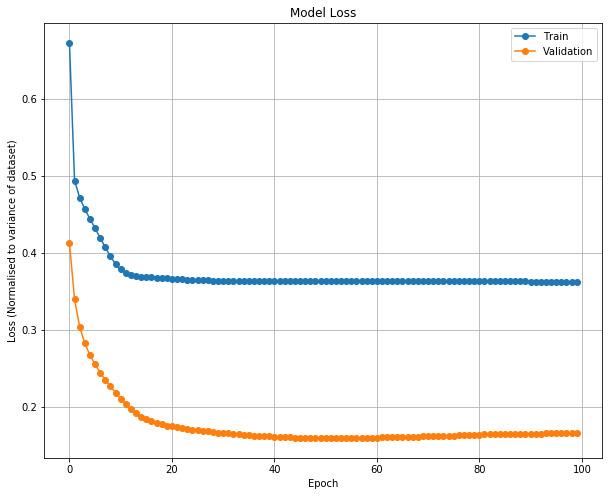

In [11]:
plotter.plot_predictions(net, x_train, y_train, x_val, y_val)
plotter.plot_loss_vs_epoch(history, var_train, var_val)

In [12]:
net.save("weights_20200429")

In [13]:
mod = keras.load_model("weights_20200429")

NameError: name 'keras' is not defined